# **Car License Plate Detection System in Parking Lot**

## **1.Introduction**

We know that the license plate is very important because it will  help us to identify our car from the crowd and will make it unique. That is why license Plate Recognition  is crucial for management in  many areas. For example, with license plate recognition system, you can manage parking lots very easily or traffic can flow smoothly without having to stop or it is used to identify the cars that are breaking the traffic rules, as the scanner will capture their license plate number automatically with a license plate recognition system. 

However, many of the current solutions are still not robust in real-world situations, commonly depending on many constraints. Our goal is creating car license plate detection system to regcognize the vehicles that will  go to parking lot  and recognize various type of license plates in various light condition quickly. We need to set up some sensor to determine the car has been stoped in the appropriate  place  before capturing image and then detect plate on predefined area such as front or back of vehicles.There are 2 steps to read automatically the vehicle license plate. Firstly, we need to identify the area( region) form the license plate itself. Then we use that to read the letters and numbers from license plate of vehicles.In the following project, we only focus on step 1 to find bounding box of the license plate.

The great thing about this model is that it helps reducing operating expenses and keeping the clients sastified. In addition to,it can replicate very easily. We can deploy the model in every parking lot.

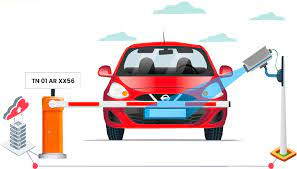

### **Dataset** 
We use the dataset from  [Kaggle](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) to collect the vehicle images where the number plate appears.This dataset contains 433 images with bounding box annotations of the car license plates within the image.
Annotations are provided in the PASCAL VOC format. This means we have label images and we can extract coordinate of license plate in each image.
 


At the begin, we download the dataset by using Kaggle API.

In [ ]:
# import libary 
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf
!pip install scikeras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import load_model, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping
import plotly.express as px
from skimage import io
from keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

import os

# Paste your username where is says 'username'
# and your API key where it say 'key'

os.environ['KAGGLE_USERNAME'] = "vannguyenntv"
os.environ['KAGGLE_KEY'] = "8fe302c657355ada906f2553cf80e595"

# Install Kaggle packages

!pip install -q kaggle
!pip install -q kaggle-cli

# Download the data set

!kaggle datasets download -d andrewmvd/car-plate-detection

# Remove the sample_data folder from our working directory

!rm -r sample_data

# If you get any errors, its likely due to conflicts in the Python versions and the Unix versions,
# but they should not be an issue. They are more warnings, then errors.
# As long as it downloads the data, you're fine.

!unzip car-plate-detection.zip

We display 4  original images of the data

  0%|          | 0/433 [00:00<?, ?it/s]

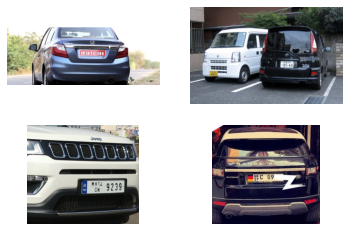

In [8]:
## get all file path image
import cv2
images = load_images('./images')
def get_file_name(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./images',filename_image)
    return filepath_image

image_path = list(df['filepath'].apply(get_file_name))
#sample images
for i in range(6,10) :
    plt.subplot(2,2,i-5)
    plt.axis('off')
    file_path = image_path[i] #path of  row 2 in dataframe
    img = cv2.imread(file_path) #read the image

    img = io.imread(file_path) #Read the image
    
    plt.imshow(img)


## **2.Data processing**


First, we need to do some data preprocessing. Since the output of the label is XML in order to use this for the training process we need data in array format. For that, we will take the useful information from the object( license plate) which are the diagonal points of the rectangle box or bounding box which are xmin, ymin, xmax, ymax respectively. This is available in XML. So we need to extract the information and save it in CSV file.

In [3]:
from tqdm.notebook import tqdm # IPython/Jupyter Notebook progressbar decorator for iterators
import xml.etree.ElementTree as xet # implement a simple and efficient API for parsing and creating XML data.
def load_images(directory):
    images = []

    for filepath in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory,filepath)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        img = cv2.medianBlur(img,5)
        images.append(img)
    
    images = np.array(images).reshape(len(images),224,224,3)
    return images
from glob import glob # module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
path = glob('./annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
#PARSING INFORMATION FROM XML
for filename in path:
    data = xet.parse(filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
# CONVERTING DATA FROM XML INTO CSV
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./annotations/Cars249.xml,118,149,91,99
1,./annotations/Cars62.xml,156,243,110,159
2,./annotations/Cars417.xml,90,273,145,196
3,./annotations/Cars132.xml,23,56,190,198
4,./annotations/Cars110.xml,286,328,133,159


Next, we want to  verify the bounding box is appearing properly for a given image. For example, we use the image N249.jpeg (row 1 in the dataframe) and the corresponding diagonal position can found in data frame. We can see the result on figure 1

  0%|          | 0/433 [00:00<?, ?it/s]


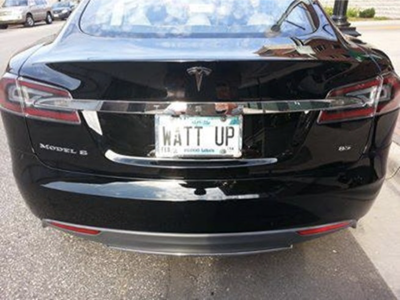

In [5]:
## get all file path image
import cv2
images = load_images('./images')
def get_file_name(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./images',filename_image)
    return filepath_image

image_path = list(df['filepath'].apply(get_file_name))

#show a sample image Car249.jpeg
#path of row 1 in dataframe
file_path = image_path[1] 
img = cv2.imread(file_path) #read the image

img = io.imread(file_path) #Read the image
fig = px.imshow(img)
#fig
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 1 - Car249.jpeg with bounding box')
fig.add_shape(type='rect',x0=df.iloc[1,1], x1=df.iloc[1,2], y0=df.iloc[1,3], y1=df.iloc[1,4], xref='x', yref='y',line_color='cyan')

This is the second image with bounding box of the license plate.


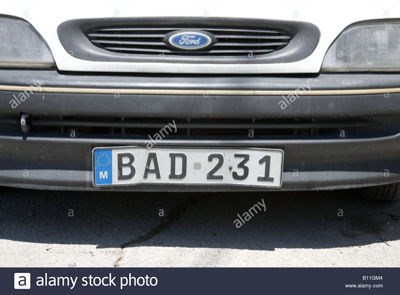

In [6]:
#show a sample image Car62.jpeg
#path of row 2 in dataframe
file_path = image_path[2] 
img = cv2.imread(file_path) #read the image

img = io.imread(file_path) #Read the image
fig = px.imshow(img)
#fig
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 2 - Car62.jpeg with bounding box')
fig.add_shape(type='rect',x0=df.iloc[2,1], x1=df.iloc[2,2], y0=df.iloc[2,3], y1=df.iloc[2,4], xref='x', yref='y',line_color='cyan')

 Next, we take each image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.After that, we normalize the image just by dividing 255 because the maximum number for an 8-bit image can store 256 possible colors, 2 power(8) = 256 -1 = 255 (Min-Max Scaler). We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. For normalizing labels, we need to divide the diagonal points with the width and height of the image.Then, we will convert the list into an array using Numpy and split the data into training and testing set using sklearn.
 

In [9]:
from sklearn.model_selection import train_test_split
bbox_coords = df.iloc[:,1:].values
labels = []

for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    xmin,xmax,ymin,ymax = bbox_coords[ind]
    nxmin, nxmax = int(xmin/(w/255.)), int(xmax/(w/255.))
    nymin, nymax = int(ymin/(h/255.)), int(ymax/(h/255.))
    labels.append((nxmin,nxmax,nymin,nymax))
labels = np.array(labels)
X = np.array(images,dtype=np.float32)
y = np.array(labels,dtype=np.float32)
X = X / 255.
y = y / 255.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)

# **3. Result**
We use pre-train VGG16 and RESNET50 on the license plate dataset. This means reusing the weights in one or more layers from the pre-trained network models in a new model and  keeping the weights fixed. We also add some more news layer and  fine tuning them.
## **VGG16 model**


We create new model by keeping the original VGG16 model and adding 4 more layer to predict the licence plate localization. We also look at tuning the batch size and number of epochs used when fitting the network to find the best performance.The reasons we want to fine tune them are 


*  The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are updated. It is also an optimization in the training of the network, defining how many patterns to read at a time and keep in memory.

*   The number of epochs is the number of times the entire training dataset is shown to the network during training because some networks are sensitive to the batch size.

Here we will evaluate a suite of different mini-batch sizes( 30,40,50) and different epochs (100,200)

In [ ]:
## skip this step for grid search if you don't have enough time(it takes about 3 hours to run grid search) and the best perfomance model will show in the next chunk


## grid search models with different epoch and batch
# def create_model():
#   model = Sequential()
#   model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
#   model.add(Flatten())
#   model.add(Dense(128, activation="relu"))
#   model.add(Dense(128, activation="relu"))
#   model.add(Dense(64, activation="relu"))
#   model.add(Dense(4, activation="sigmoid"))

#   model.layers[-6].trainable = False
#   model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#   return model
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasRegressor
# # create model
# model = KerasRegressor(model=create_model, verbose=1)
# # define the grid search parameters
# batch_size = [ 30, 40,50]
# epochs = [ 100, 200]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
#   # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
# grid_result = grid.fit(X_train,y_train,validation_data=(X_val,y_val), callbacks=[es] ) 

# ##summarize grid results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# params = grid_result.cv_results_['params']
# for mean, param in zip(means,  params):
#     print("%f  with: %r" % (mean, param))

The grid search result showed that VGG16 model with batch size 30 and epochs 100 optimized architecture achieves the best performance with  the EarlyStopping callback of the loss on the validation dataset. The evaluation results based on mean test score. We will rerun the best model to see the accuracy and prediction on the test set.

In [ ]:
## VGG16 with epochs=200 and batch_size=60
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [44]:
## fit the model
#  early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
r = model.fit(X_train,
              y_train,
              epochs=100,
              batch_size=30,
              validation_data=(X_val,y_val),
              verbose=1 
              , callbacks=[es] # using early stop
              )
#evaluate the model
loss, acc = model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

Epoch 1/200
7/7 [==============================] - 2s 314ms/step - loss: 0.0076 - accuracy: 0.8514 - val_loss: 0.0367 - val_accuracy: 0.5128
Epoch 2/200
7/7 [==============================] - 2s 313ms/step - loss: 0.0077 - accuracy: 0.8486 - val_loss: 0.0372 - val_accuracy: 0.5385
Epoch 2: early stopping
2/2 [==============================] - 0s 74ms/step - loss: 0.1362 - accuracy: 0.2727
Test Loss: 0.13624916970729828
Test Accuracy: 0.27272728085517883


In [46]:
## fit the model
# without early stopping

r = model.fit(X_train,
              y_train,
              epochs=100,
              batch_size=30,
              validation_data=(X_val,y_val),
              verbose=1             
              )
#evaluate the model
loss, acc = model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

Epoch 1/100
12/12 [==============================] - 2s 177ms/step - loss: 0.0078 - accuracy: 0.8429 - val_loss: 0.0369 - val_accuracy: 0.5641
Epoch 2/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0079 - accuracy: 0.8486 - val_loss: 0.0371 - val_accuracy: 0.5897
Epoch 3/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0078 - accuracy: 0.8486 - val_loss: 0.0368 - val_accuracy: 0.5385
Epoch 4/100
12/12 [==============================] - 2s 189ms/step - loss: 0.0078 - accuracy: 0.8514 - val_loss: 0.0368 - val_accuracy: 0.5641
Epoch 5/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0081 - accuracy: 0.8457 - val_loss: 0.0375 - val_accuracy: 0.5641
Epoch 6/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0081 - accuracy: 0.8629 - val_loss: 0.0367 - val_accuracy: 0.5385
Epoch 7/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0080 - accuracy: 0.8229 - val_loss: 0.0377 - val_accuracy: 0.5128

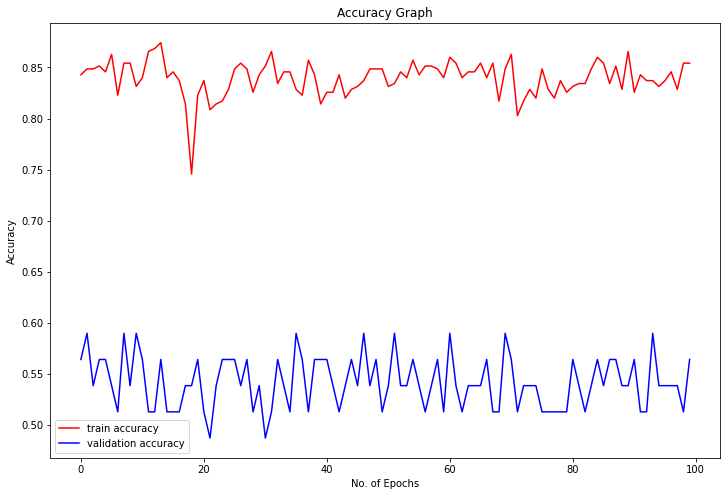

In [47]:
#visualize accuracy
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

The results have shown that the model is able to perform with high accuracy of nearly 65 percent in recognizing license plates.Next we will visualize the prediction of some random image of test set and google images.

2/2 [==============================] - 0s 189ms/step


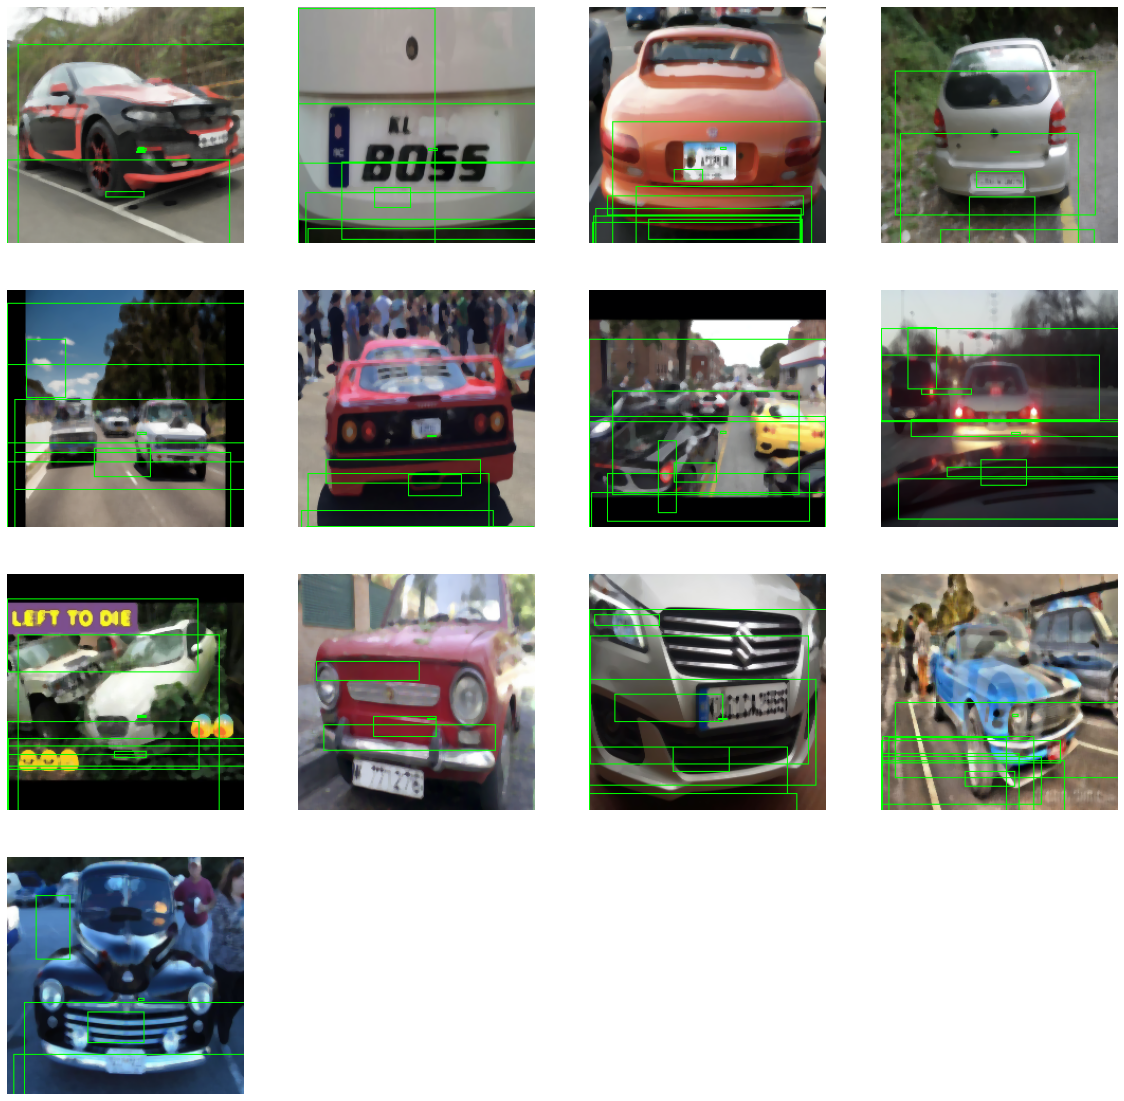

In [75]:
#predict some of images on test set
y_vgg16 = model.predict(X_test)
plt.figure(figsize=(20,20))
for i in range(0,13) :
    plt.subplot(4,4,i+1)
    plt.axis('off')
    ny = y_vgg16[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

--2023-01-13 15:56:17--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 108.177.126.139, 108.177.126.113, 108.177.126.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7875 (7.7K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A’

images?q=tbn:ANd9Gc 100%[===================>]   7.69K  --.-KB/s    in 0s      

2023-01-13 15:56:17 (91.9 MB/s) - ‘images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A’ saved [7875/7875]

1/1 [==============================] - 1s 670ms/step
(93, 87) (164, 109)



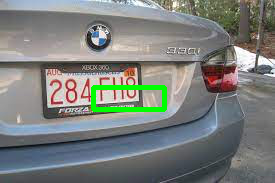

In [51]:
# download a  image from google
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A&usqp=CAU
# Visualize the prediction
path= './images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='VGG16 prediction')

We see that the prediction ( green boudding box) close with car license plate in the images but it isn't good enough to extract the leters and numbers of the license plate above.

##  **Inception RESNET-V2 model**

In [59]:
# create the RESNET model
inception_resnet= InceptionResNetV2(input_tensor= Input(shape= (224,224,3)))
model_2 = inception_resnet.output
model_2= Flatten()(model_2)
model_2 = Dense(400, activation= "relu" )(model_2)
model_2 = Dense(200, activation = "relu") (model_2)
model_2= Dense(4, activation= "sigmoid") (model_2)
resnet_model= Model(inputs= inception_resnet.input, outputs= model_2)


In [63]:
resnet_model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),metrics=['accuracy'])
#resnet_model.summary
## Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history= resnet_model.fit(x= X_train, y= y_train, batch_size=30, epochs=200, validation_data= (X_test, y_test), callbacks= [es])

Epoch 1/200
12/12 [==============================] - 36s 1s/step - loss: 0.0426 - accuracy: 0.4229 - val_loss: 0.0444 - val_accuracy: 0.3636
Epoch 2/200
12/12 [==============================] - 7s 558ms/step - loss: 0.0396 - accuracy: 0.5371 - val_loss: 0.0408 - val_accuracy: 0.4318
Epoch 2: early stopping


In [64]:
loss, acc = resnet_model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

2/2 [==============================] - 2s 842ms/step - loss: 0.0408 - accuracy: 0.4318
Test Loss: 0.04076261445879936
Test Accuracy: 0.4318181872367859


The results have shown that the model is able to perform with high accuracy of nearly 65 percent in recognizing license plates.Next we will visualize the prediction of some random image of test set and google images.

1/1 [==============================] - 4s 4s/step
(134, 95) (143, 97)



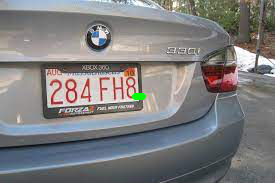

In [69]:
# download a  image from google
#!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A&usqp=CAU
# Visualize the prediction
path= './images?q=tbn:ANd9GcQux352VjtWonwTNLu5MsH26XP3U0LGLC1wu7qKnhC0O986fmzQDfNMMYpvDTA8UERFn4A'
def RESNET_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = resnet_model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = RESNET_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Prediction of RESNET model')

We see that the green bounding box is too small comparing with the license plate in the image above

2/2 [==============================] - 0s 234ms/step


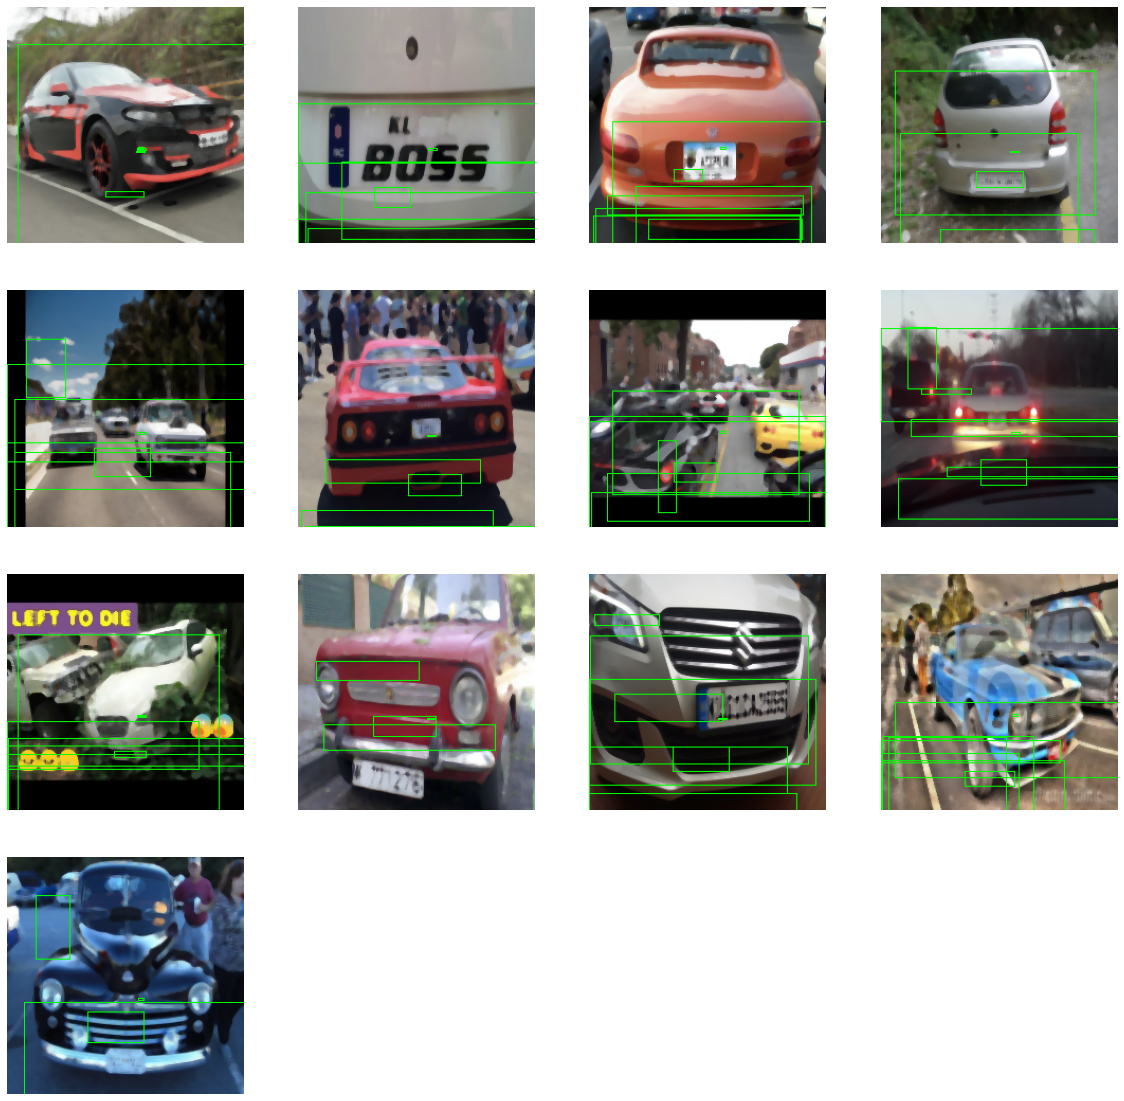

In [74]:
#predict some of images on test set
y_resnet = resnet_model.predict(X_test)
plt.figure(figsize=(20,20))
for i in range(0,13) :
    plt.subplot(4,4,i+1)
    plt.axis('off')
    ny = y_resnet[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

We notify that the model predicta multiple bounding box. It might helpful if there are multiple cars in 1 image but the prediction is not correct.

# **4. Conclusion**
The system has successfully implemented with various kind of linces plate but the accuary is not high due to limit of resources(GPU, time)

The model still needs further reseach to improve accuracy